<a href="https://colab.research.google.com/github/tyfmanlapaz/Data-Science/blob/deep-learning/Pneumonia_Classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluating the efficacy of a Conventional CNN model and pre-trained CNN model for image recognition**

In this activity, we will be developing a conventional CNN and as well as a pre-trained CNN model for classificying Pneumonia from Chest X-ray images

# 1. Data Collection (Obtain Data)

**1.1 Importing Libraries**

In [71]:
# load libraries
import pandas as pd
import numpy as np
import random
import os
import glob
from google.colab import drive
import itertools
from PIL import Image

# plotting libraries
import seaborn as sns
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
#sns.set() # Setting seaborn as default style even if use only matplotlib

# DL and ML Libraries
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


# environment seeds for reproducibility
seed_value = 42
from numpy.random import seed
seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)                   # Set the random seed in tensorflow at graph level
os.environ['PYTHONHASHSEED'] = str(seed_value)   # Set the seed for hash based operations in python
os.environ['TF_DETERMINISTIC_OPS'] = '1'         # Set seed for TF operations


pd.options.display.max_colwidth = 100

**1.2 Authenticating and Mounting the Dataset**

In [3]:
# authenticating and mounting GDrive
drive.mount('/content/drive')

#extracting contents of the zip file and loading it to gcolab
from zipfile import ZipFile

# defining path to zip file
cxr_zip_path = '/content/drive/My Drive/GoogleColab/Datasets/CXR.zip'

# creating directory to extract files
cxr_extract_dir = '/content/datasets'
os.makedirs(cxr_extract_dir, exist_ok=True)

# extract zip files to gcolab storage/directory
with ZipFile(cxr_zip_path, 'r') as cxr_zip_ref:
    cxr_zip_ref.extractall(cxr_extract_dir)

# define main dataset directory
main_dir = cxr_extract_dir

Mounted at /content/drive


**1.3 Loading the PreSplit Datasets into Dataframes**

In [4]:
# function to load image dataset into dataframes
def get_datasets(main_dir, split_type):
  data_split_dir = os.path.join(main_dir, split_type)
  data_normal = glob.glob(data_split_dir + "/NORMAL/*.jpeg")
  data_pneumonia = glob.glob(data_split_dir + "/PNEUMONIA/*.jpeg")

  data_list = [x for x in data_normal]
  data_list.extend([x for x in data_pneumonia])

  split_df = pd.DataFrame(np.concatenate([['Normal'] * len(data_normal) , ['Pneumonia'] * len(data_pneumonia)]), columns = ['class'])
  split_df['image_data'] = [x for x in data_list]

  return split_df

In [5]:
# load training dataset into dataframe
train_df = get_datasets(main_dir, "train").sample(frac = 1, random_state = seed_value).reset_index(drop = True)
print(f'\nShape of Training data {train_df.shape}')
train_df.head()


Shape of Training data (5216, 2)


,class,image_data
0,Pneumonia,/content/datasets/train/PNEUMONIA/person704_virus_1301.jpeg
1,Normal,/content/datasets/train/NORMAL/IM-0356-0001.jpeg
2,Pneumonia,/content/datasets/train/PNEUMONIA/person406_bacteria_1819.jpeg
3,Pneumonia,/content/datasets/train/PNEUMONIA/person771_bacteria_2675.jpeg
4,Pneumonia,/content/datasets/train/PNEUMONIA/person1524_bacteria_3984.jpeg


In [6]:
# load testing dataset into dataframe
test_df = get_datasets(main_dir, "test").sample(frac = 1, random_state = 10).reset_index(drop = True)
print(f'\nShape of Testing data {test_df.shape}')
test_df.head()


Shape of Testing data (624, 2)


,class,image_data
0,Normal,/content/datasets/test/NORMAL/NORMAL2-IM-0329-0001.jpeg
1,Pneumonia,/content/datasets/test/PNEUMONIA/person141_bacteria_676.jpeg
2,Pneumonia,/content/datasets/test/PNEUMONIA/person149_bacteria_713.jpeg
3,Pneumonia,/content/datasets/test/PNEUMONIA/person1642_virus_2842.jpeg
4,Normal,/content/datasets/test/NORMAL/NORMAL2-IM-0374-0001-0001.jpeg


In [7]:
# load validation dataset into dataframe
validation_df = get_datasets(main_dir, "val").sample(frac = 1, random_state = seed_value).reset_index(drop = True)
print(f'\nShape of Validation data {validation_df.shape}')
validation_df.head()


Shape of Validation data (16, 2)


,class,image_data
0,Normal,/content/datasets/val/NORMAL/NORMAL2-IM-1442-0001.jpeg
1,Normal,/content/datasets/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
2,Normal,/content/datasets/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
3,Pneumonia,/content/datasets/val/PNEUMONIA/person1950_bacteria_4881.jpeg
4,Pneumonia,/content/datasets/val/PNEUMONIA/person1952_bacteria_4883.jpeg


In [8]:
# examine column data types, number of non-null values, and memory usage
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class       5216 non-null   object
 1   image_data  5216 non-null   object
dtypes: object(2)
memory usage: 81.6+ KB
None


In [9]:
# Understanding Data Labels/Class
print(f'Number of Unique Labels (Class): {train_df.iloc[:,0].nunique()}')
print(f'The Unique Values: {train_df.iloc[:,0].unique()}')

Number of Unique Labels (Class): 2
The Unique Values: ['Pneumonia' 'Normal']


**1.4 Visualize Class Distributions**

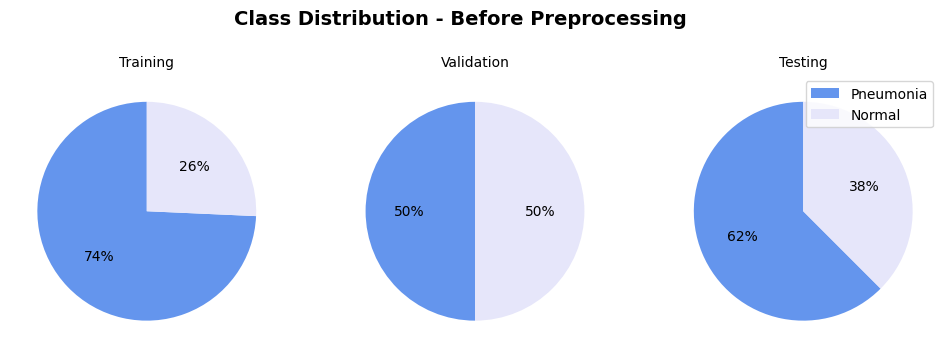

In [10]:
# Function to create the dataset distribution pie chart plots
def create_distribution_plots(data_dict, title):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  fig.suptitle('Class Distribution - ' + title, fontsize=14, fontweight='bold', ha='center', y=1)
  chart_colors = ['cornflowerblue','lavender']
  #chart_colors = ['orchid', 'lavender']
  subtitle_props = {'fontsize': 10, 'ha': 'center'}
  index = 0

  for split_name, data_name in data_dict.items():

    label_counts = data_name['class'].value_counts() #set labels
    #labels_str = label_counts.index

    # Subplots
    data_wedge = axes[index].pie(label_counts, autopct='%1.0f%%', startangle=90, colors=chart_colors)
    axes[index].set_title(split_name, subtitle_props)
    index = index + 1

  # Create a legend outside the plot using wedges and labels from subplots
  labels = label_counts.index.to_numpy()  # Assuming class labels are in the index
  legend_patches = data_wedge[0]  # Get wedge patches from the first subplot
  plt.legend(legend_patches, labels, loc='upper right', fontsize=10)
  plt.show()

# call function to plot datasets before pre-processing
original_data_dict = {'Training': train_df, 'Validation': validation_df, 'Testing': test_df}
create_distribution_plots(original_data_dict, 'Before Preprocessing')

**1.5 Visualize Chest X-Ray Raw Images**

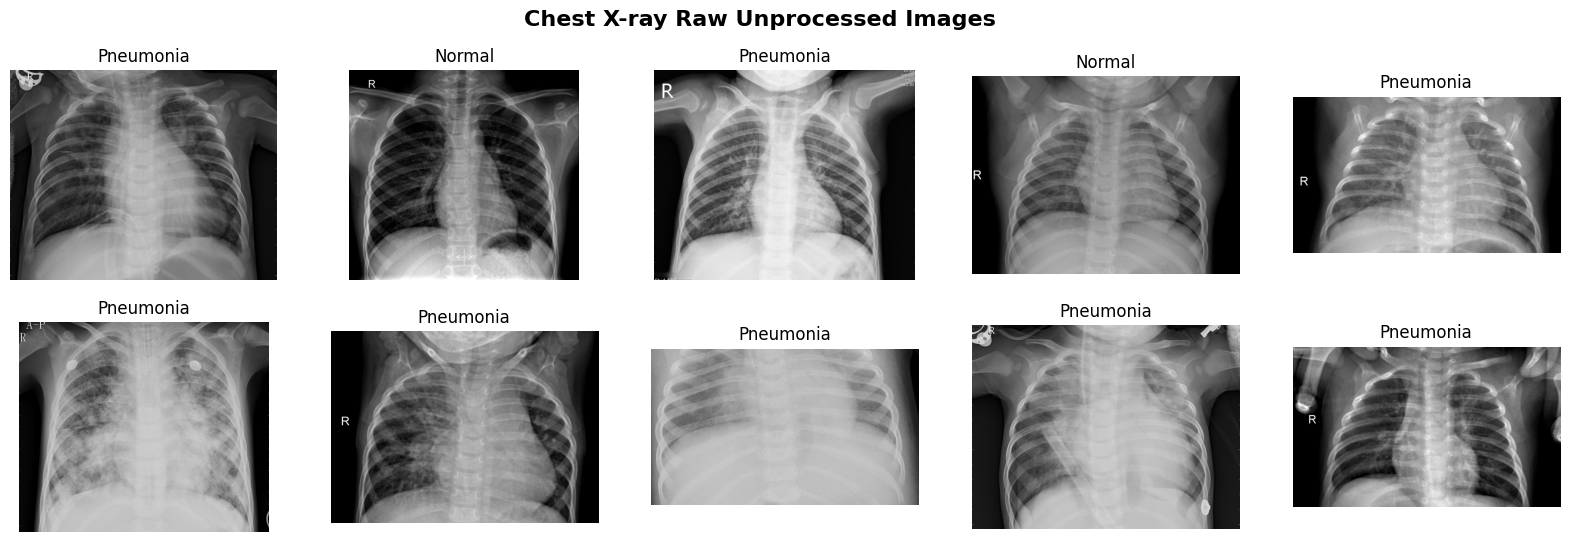

In [11]:
rows = 2
columns = 5

sample_dataset = pd.concat([train_df, test_df, validation_df])
random_samples = random.sample(range(len(sample_dataset)), rows * columns)

fig, axes = plt.subplots(rows, columns, figsize = (20, 6))
fig.suptitle('Chest X-ray Raw Unprocessed Images', fontsize=16, fontweight='bold', ha='center')

for i, index in enumerate(random_samples):
    row = i // columns
    col = i % columns
    img_path = sample_dataset['image_data'].iloc[index]
    label = sample_dataset['class'].iloc[index]
    img = Image.open(img_path)
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 12, ha='center')

plt.show()

# these image sizes have different dimensions

# 2. Data Preprocessing (Scrubbing)

**2.1 Merge Training and Validation Datasets**

First, I will be merging the train and validation set as the validation set is too small. I will then create a stratified sample split, with an 80% for training and 20% for validation.

In [12]:
# combine training and validation datasets since validation dataset is very few
train_val_df = pd.concat([train_df, validation_df])
train_val_df.shape

(5232, 2)

In [13]:
# create new training and validation sets with an 80:20 split ratio
new_train_df, new_validation_df = train_test_split(train_val_df, test_size = 0.20, random_state = seed_value, stratify = train_val_df['class'])

In [14]:
new_train_df.sample(5)

,class,image_data
1100,Pneumonia,/content/datasets/train/PNEUMONIA/person1233_bacteria_3188.jpeg
1579,Pneumonia,/content/datasets/train/PNEUMONIA/person855_bacteria_2777.jpeg
3017,Pneumonia,/content/datasets/train/PNEUMONIA/person36_bacteria_182.jpeg
3262,Normal,/content/datasets/train/NORMAL/NORMAL2-IM-1142-0001-0001.jpeg
2274,Pneumonia,/content/datasets/train/PNEUMONIA/person1528_bacteria_3991.jpeg


In [15]:
new_validation_df.sample(5)

,class,image_data
1628,Pneumonia,/content/datasets/train/PNEUMONIA/person1056_virus_1755.jpeg
2963,Pneumonia,/content/datasets/train/PNEUMONIA/person1231_bacteria_3186.jpeg
1136,Pneumonia,/content/datasets/train/PNEUMONIA/person1153_virus_1932.jpeg
4970,Pneumonia,/content/datasets/train/PNEUMONIA/person1165_bacteria_3111.jpeg
3007,Pneumonia,/content/datasets/train/PNEUMONIA/person336_bacteria_1548.jpeg


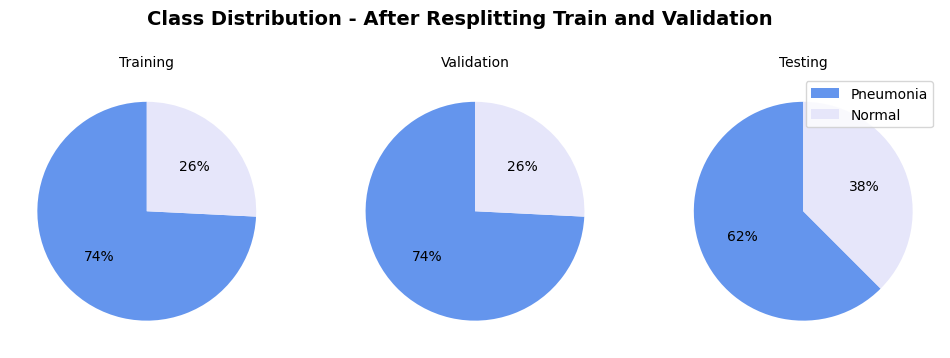

In [16]:
# call function to plot datasets distribution after resplitting train and validation sets
new_data_dict = {'Training': new_train_df, 'Validation': new_validation_df, 'Testing': test_df}
create_distribution_plots(new_data_dict, 'After Resplitting Train and Validation')

In [17]:
print("Dataset Shapes \n========================================")
print(f'Training Dataset: {new_train_df.shape}')
print(f'Validation Dataset: {new_validation_df.shape}')
print(f'Testing Dataset: {test_df.shape}')

Dataset Shapes 
Training Dataset: (4185, 2)
Validation Dataset: (1047, 2)
Testing Dataset: (624, 2)


**2.2 Data Augmentation**

***Augment the datasets to handle the class imbalances to help reduce overfitting.***

First, build a new generator for validation and testing data.

Why can't use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning that it uses batch statistics. We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data). What we need to do is to normalize incoming test data using the statistics computed from the training set.

In [18]:
# constant values to be used for further processing
image_size = 224 #changed from 224 to 255 to be divisible by filter size
batch_size = 32
#seed_value for seed

In [19]:
%%time
# *** data augmentation ***

def perform_data_augmentation():
  # generator for training set
  augment_train = ImageDataGenerator(rescale=1/255., zoom_range = 0.01,  width_shift_range = 0.1 , height_shift_range = 0.1,
                                      horizontal_flip = False, vertical_flip = False, brightness_range = [0.95, 1.05], fill_mode = 'nearest') #rotation_range = 5,

  # generator for testing and validation set which will only rescale the image
  augment_testval = ImageDataGenerator(rescale=1/255.)

  train_images = augment_train.flow_from_dataframe(new_train_df, x_col = 'image_data', y_col = 'class', class_mode = 'binary', color_mode='grayscale',
                                              batch_size = batch_size, target_size = (image_size, image_size), shuffle = True, seed = seed_value)

  validation_images = augment_testval.flow_from_dataframe(new_validation_df, x_col = 'image_data', y_col = 'class', class_mode = 'binary',
                                              batch_size = batch_size, target_size = (image_size, image_size), color_mode='grayscale',
                                              shuffle = True, seed = seed_value)

  test_images = augment_testval.flow_from_dataframe(test_df, x_col = 'image_data', y_col = 'class', class_mode = 'binary', color_mode='grayscale',
                                              batch_size = batch_size, target_size = (image_size, image_size), shuffle = False)

  return train_images, validation_images, test_images

train_images, validation_images, test_images = perform_data_augmentation() # call function

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
CPU times: user 40.6 ms, sys: 21 ms, total: 61.6 ms
Wall time: 62.2 ms


Exploring Augmented Train Data 
Training Dataset Shape: (4185, 2)
Image Dimensions: 224 pixels width x  224 pixels height, single color channel.
Max Pixel Value: 1.0000, Minimum Pixel Value: 0.0000 - after Normalization
Mean Pixel Value: 0.4808 , STD: 0.2392


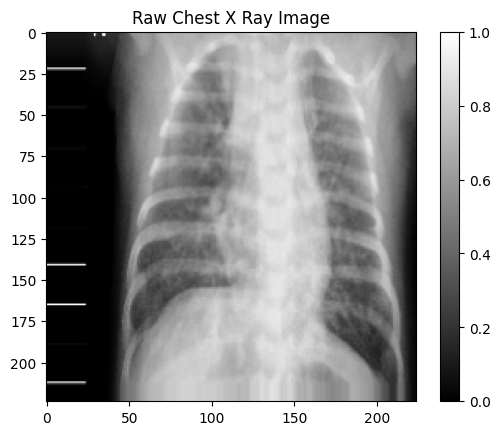

In [20]:
generated_image, label = train_images.__getitem__(1)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print("Exploring Augmented Train Data \n========================================")
print(f'Training Dataset Shape: {new_train_df.shape}')
print(f"Image Dimensions: {generated_image.shape[1]} pixels width x  {generated_image.shape[2]} pixels height, single color channel.")
print(f"Max Pixel Value: {generated_image.max():.4f}, Minimum Pixel Value: {generated_image.min():.4f} - after Normalization")
print(f"Mean Pixel Value: {generated_image.mean():.4f} , STD: {generated_image.std():.4f}")


**2.3 Class Weights**

Since data augmentation alone is not optimal to treat class imbalances, class weights are needed to compensate the imbalance in the dataset.

By assigning higher weights to the minority class (Normal) and lower weights to the majority class (Pneumonia), the algorithm can be encouraged to pay more attention to the minority class during training.

In [21]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_images.classes), y=train_images.classes)
class_weight_dict = {idx: weight for idx, weight in enumerate(class_weights)}

# validate if class weights are available
if class_weight_dict is None:
  print('WARNING: Class Weights are not defined. No weights will be used in the model.fit call!')
else:
  print('Class Weights available: ', class_weight_dict)

Class Weights available:  {0: 1.9392956441149212, 1: 0.6736960721184804}


# 3. Modelling: Conventional CNN

**3.1 Setting Callbacks**

**EarlyStopping** - prevent overfitting by stopping the training process when the validation loss fails to improve for a certain number of epochs (consecutive training iterations).

**ReduceLROnPlateau** - addresses the situation where the training process gets stuck in a local minimum (not the global minimum) and validation loss stops decreasing.

In [22]:
# setting callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-7, restore_best_weights=True, verbose = 1)
plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2, min_delta = 1e-7, cooldown = 0, verbose = 1)

**3.2 Defining the Model Architechture**

In [54]:
#--------------------------------------------------------------------------------------#
# 3.2 Define model Architechture
#--------------------------------------------------------------------------------------#
def define_cnn_model():

    # set width, height, color channel (224,224,1)
    inputs = layers.Input(shape=(image_size, image_size, 1))

    # Feature Extraction Layer - Start
    # Block1
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    #x = layers.Dropout(0.2)(x)

    # Block2
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    #x = layers.Dropout(0.2)(x)

    # Block3
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    #x = layers.Dropout(0.2)(x)

    # Block4
    x = layers.Conv2D(filters=64, kernel_size=(3,3),  padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3),  padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)
    # Feature Extraction Layer - End

    # Classification Layer - Start
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    # Classification Layer - End

    conv_cnn_model = keras.Model(inputs=[inputs], outputs=output)

    return conv_cnn_model

**3.3 Load Model and obtain summary**

In [55]:
#--------------------------------------------------------------------------------------#
# 3.3 Compile Model and Obtain Summary
#--------------------------------------------------------------------------------------#
keras.backend.clear_session()

base_cnn_model = define_cnn_model()
base_cnn_model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=1e-3), metrics='binary_accuracy')
base_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640  

**3.4 Model Training Phase**

In [56]:
#--------------------------------------------------------------------------------------#
# 3.4 Model Training
#--------------------------------------------------------------------------------------#
%%time
train_history = base_cnn_model.fit(train_images,
          batch_size = batch_size,
          epochs = 15,
          class_weight=class_weight_dict,
          validation_data=validation_images,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(new_train_df)/batch_size),
          validation_steps=(len(new_validation_df)/batch_size));

Epoch 1/15
130/130 [==============================] - 70s 500ms/step - loss: 0.5774 - binary_accuracy: 0.8294 - val_loss: 2.4059 - val_binary_accuracy: 0.7421 - lr: 0.0010
Epoch 2/15
130/130 [==============================] - 60s 458ms/step - loss: 0.2605 - binary_accuracy: 0.8949 - val_loss: 3.4431 - val_binary_accuracy: 0.7421 - lr: 0.0010
Epoch 3/15
130/130 [==============================] - 63s 479ms/step - loss: 0.1979 - binary_accuracy: 0.9214 - val_loss: 1.7914 - val_binary_accuracy: 0.7421 - lr: 0.0010
Epoch 4/15
130/130 [==============================] - 65s 496ms/step - loss: 0.1975 - binary_accuracy: 0.9171 - val_loss: 0.3236 - val_binary_accuracy: 0.8739 - lr: 0.0010
Epoch 5/15
130/130 [==============================] - 61s 466ms/step - loss: 0.1295 - binary_accuracy: 0.9460 - val_loss: 0.2605 - val_binary_accuracy: 0.9121 - lr: 0.0010
Epoch 6/15
130/130 [==============================] - 61s 469ms/step - loss: 0.1403 - binary_accuracy: 0.9481 - val_loss: 0.3922 - val_binar

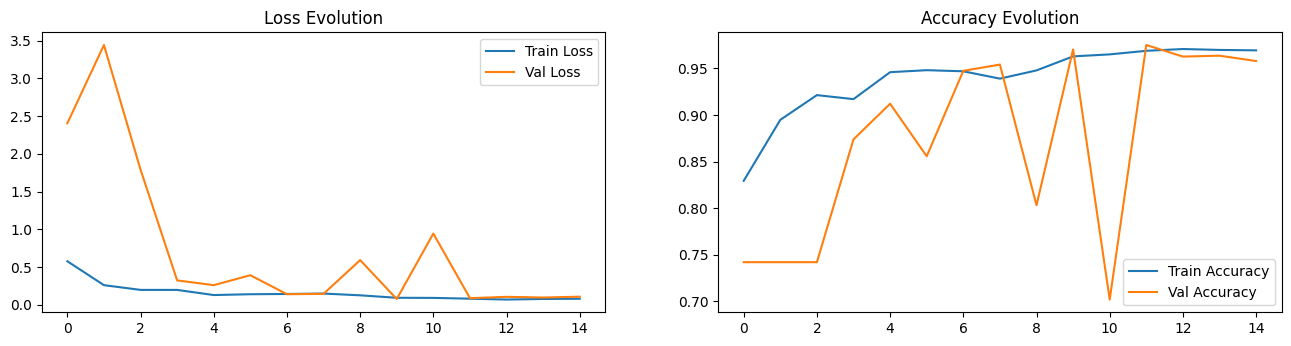

In [61]:
mat.rc_file_defaults() #clear sns default


plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(train_history.history['loss'], label='Train Loss')
plt.plot(train_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(train_history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(train_history.history['val_binary_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

In [59]:
cnn_val_score_v1 = base_cnn_model.evaluate(validation_images,  verbose = 0)
print('Val loss:', cnn_val_score_v1[0])
print('Val accuracy:', cnn_val_score_v1[1])

Val loss: 0.07694125920534134
Val accuracy: 0.970391571521759


In [60]:
# get test accuracy
cnn_test_score_v1 = base_cnn_model.evaluate(test_images,  verbose = 0)

print('Test loss:', cnn_test_score_v1[0])
print('Test accuracy:', cnn_test_score_v1[1])

Test loss: 0.6484667062759399
Test accuracy: 0.8237179517745972


**3.5 Predictions on Test Data**

In [68]:
# Predict on Unseen Features/Test Data
class_labels = list(train_images.class_indices.keys())
cnn_test_classes = test_images.classes

#predict
cnn_predicted_classes = np.round(base_cnn_model.predict(test_images, verbose = 0))

In [69]:
# Generate Classification Report
class_report_v1 = classification_report(cnn_test_classes, cnn_predicted_classes, target_names = class_labels)
print("Base CNN Model - Classification Report (Test) \n=================================================================")
print(class_report_v1)

Base CNN Model - Classification Report (Test) 
              precision    recall  f1-score   support

      Normal       0.96      0.55      0.70       234
   Pneumonia       0.79      0.99      0.88       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



In [78]:
def get_performance_metrics(model_name, y_test, y_pred, model, class_labels):
    """
    Generate performance metrics for a given model.

    Args:
        model_name (str): The name of the model.
        y_test (pd.Series): True labels of the test data.
        y_pred (np.ndarray): Predicted labels of the test data.
        model (classifier): Trained machine learning model.
    Returns:
        pd.DataFrame: A DataFrame containing performance metrics for the model.
    """
    # Generate confusion_matrix plot
    class_labels = class_labels
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cnn_test_matrix, display_labels = class_labels)
    disp.plot(cmap='Blues')
    plt.title(f'{model_name}')
    #plt.savefig(f'./plots/models/{model_name}.png')

    # get confusion matrix result values
    false_positive = cm[0][1]   # no. of pneumonia cases incorrectly classified as pneumonia
    false_negative = cm[1][0]   # no. of normal incorrectly classified as normal

    # print results to terminal/notebook pane
    print('< --------------------- False Positive and False Negative Rates --------------- >')
    print('---------------------------------------------------------------------------------')
    print(f"No. of Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: {false_positive}")
    print(f"No. of Normal cases incorrectly classified as Normal, its actually Pneumonia: {false_negative}")
    print('\n---------------------------------------------------------------------------------')

    # Calculate performance metrics for each model and return
    model_metrics = {
            'Model': [f'{model_name}'],
            'Accuracy': [round(accuracy_score(y_test, y_pred) * 100, 3)],
            'Precision': [round(precision_score(y_test, y_pred) * 100, 3)],
            'Recall': [round(recall_score(y_test, y_pred) * 100, 3)],
            'F1-Score': [round(f1_score(y_test, y_pred) * 100, 3)],
            'FP': [false_positive],
            'FN': [false_negative],
    }

    # Create a DataFrame from the list of dictionaries
    metrics_df = pd.DataFrame(model_metrics)

    # Return the DataFrame
    return metrics_df

< --------------------- False Positive and False Negative Rates --------------- >
---------------------------------------------------------------------------------
No. of Pneumonia cases incorrectly classified as Pneumonia, its actually Normal: 105
No. of Normal cases incorrectly classified as Normal, its actually Pneumonia: 5

---------------------------------------------------------------------------------
<---------------------------- CNN Model Performance ---------------------------->
            Model  Accuracy  Precision  Recall  F1-Score   FP  FN
0  Conv CNN Model    82.372     78.571  98.718      87.5  105   5

---------------------------------------------------------------------------------


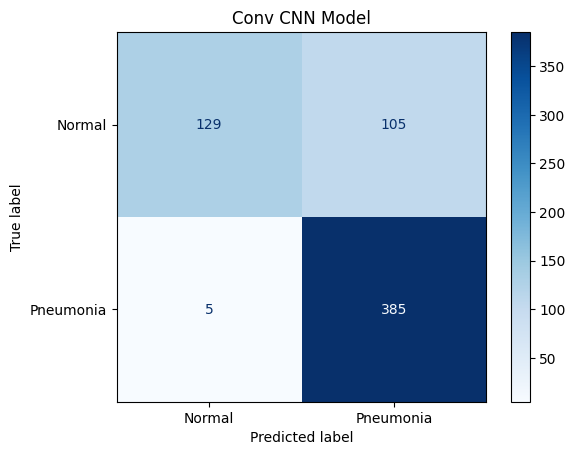

In [82]:
# Get Metrics for CNN Base Model
cnn_performance_df = get_performance_metrics('Conv CNN Model',
                                      cnn_test_classes, cnn_predicted_classes, base_cnn_model, class_labels)
print('<---------------------------- CNN Model Performance ---------------------------->')
print(cnn_performance_df)
print('\n---------------------------------------------------------------------------------')

# 4. Modelling: Pretrained Model -